In [89]:
from vqa_dataset import VQADataset
from models import BaselineNet
import torch
from torch import nn
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
val_dataset = VQADataset(
        image_dir='data/val2014/',
        question_json_file_path='data/OpenEnded_mscoco_val2014_questions.json',
        annotation_json_file_path='data/mscoco_val2014_annotations.json',
        image_filename_pattern="COCO_val2014_{}.jpg"
    )
_id2answer = {
    v: k for k, v in val_dataset.answer_to_id_map.items()}
_id2answer[len(_id2answer)] = 'Other'
for n, data in enumerate(val_dataset):
    if n==2:
        print(data.keys())
        break


dict_keys(['image', 'question', 'answers', 'orig_img'])
dict_keys(['image', 'question', 'answers', 'orig_img'])
dict_keys(['image', 'question', 'answers', 'orig_img'])


In [4]:
#val_dataset.answer_to_id_map.keys()
answers = [_id2answer[idx.item()] for idx in torch.where(data['answers'] == torch.max(data['answers']))[0]]
answer_idx = torch.argmax(data['answers']).item()
print(answers, answer_idx)

['wood'] 24


In [93]:
model = BaselineNet(n_answers=5217)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [203]:
text_feat_out = model.compute_text_feats([data['question']])
im_feat_out = model.compute_vis_feats(data['image'].unsqueeze(0))
cls_out = model.classifier(torch.cat((text_feat_out, im_feat_out),axis=1))
print(text_feat_out.size(), im_feat_out.size(), cls_out.size())

torch.Size([1, 768]) torch.Size([1, 512]) torch.Size([1, 5217])


In [128]:
torch.where(torch.argmax(cls_out, axis=1)==torch.argmax(data['answers'].unsqueeze(0), axis=1))[0]

tensor([], dtype=torch.int64)

In [157]:
_id2answer[torch.argmax([data][torch.zeros(1, dtype=torch.int64)]['answers']).item()]

'wood'

### Task 3: Transformer

In [204]:
from models import CrossAttentionLayer,BaselineNet,TransformerNet

In [205]:
model = [TransformerNet(5217), CrossAttentionLayer(256, n_heads=8)][0]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<b> Token and text encoder

In [161]:
# text converted tokens 
token = model.tokenizer.batch_encode_plus(
    [data['question']], padding="longest", return_tensors="pt"
)
token_ids, mask = token['input_ids'], token['attention_mask']
print(len(token_ids[0]), len(mask[0]))
encoded_text = model.text_encoder(**token)
print(encoded_text.keys())
last_h, pool_out = [v[1] for v in encoded_text.items()]
print(last_h.size(), pool_out.size())

12 12
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([1, 12, 768]) torch.Size([1, 768])


In [79]:
x_embed = (~torch.zeros(1, 49, 49).bool()).cumsum(2, dtype=torch.float32)[:,:,:,None]
x_embed = (x_embed - 0.5) / (x_embed[:, :, -1:] + 1e-7) * 2*np.pi
dim_t = torch.arange(128, dtype=torch.float32)
dim_t = 1e5 ** (2 * (dim_t // 2) / 128)
pos_x = (emb_x/dim_t)
pos_x2 = torch.stack(
        (pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4
    ).flatten(3)

pos = torch.cat((pos_x2, pos_x2), dim=3).permute(0, 3, 1, 2)
print(x_embed.size(), dim_t.size(), pos_x.size(), pos_x2.size(), pos.size())
# (1, 49, 49) of True

torch.Size([1, 49, 49, 1]) torch.Size([128]) torch.Size([1, 49, 49, 128]) torch.Size([1, 49, 49, 128]) torch.Size([1, 256, 49, 49])


C:\Users\Mo\AppData\Local\Temp/ipykernel_20412/3457502429.py:4: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = 1e5 ** (2 * (dim_t // 2) / 128)


<b> Model

In [203]:
model.text_encoder.config.hidden_size

768

In [207]:
text_feats, text_mask = model.compute_text_feats([data['question']])
img_feats, img_emb = model.compute_vis_feats(data['image'].unsqueeze(0))
output = model(data['image'].unsqueeze(0), [data['question']])
# print(text_feats.size(),text_mask.size(),'\n',
#       img_feats.size(), img_emb.size())
print(output.size())

torch.Size([1, 12, 256]) torch.Size([1, 49, 256])
torch.Size([1, 12, 256]) torch.Size([1, 49, 256])
torch.Size([1, 5217])


In [202]:
output.size()

torch.Size([1, 5217])

<b> positional embeddings: sin/cos with dimension (128 x 2)

## Bonus: LSTM

In [242]:
from models import LSTMNet

In [243]:
model = LSTMNet()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [227]:
text_feat_out = model.compute_text_feats([data['question']])
im_feat_out = model.compute_vis_feats(data['image'].unsqueeze(0))
print(text_feat_out.size(), im_feat_out.size())

torch.Size([1, 12, 768]) torch.Size([1, 512])


In [244]:
output = model(data['image'].unsqueeze(0), [data['question']])
print(output.size())

torch.Size([1, 12, 1536]) torch.Size([1, 3072])
torch.Size([1, 5217])


### Plotting

In [9]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

In [10]:
with open('all_answers.txt','r(') as f:
    data = f.read().split(',')

In [20]:
ser = pd.Series(data)
cts = ser.value_counts()

<AxesSubplot:title={'center':'Predicted Frequencies (top 10)'}>

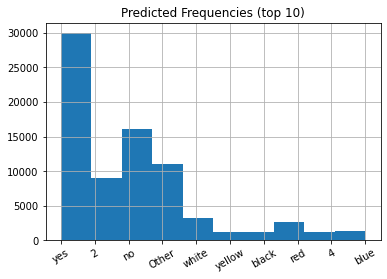

In [16]:
fig, ax = plt.subplots(1)
ax.set_title('Predicted Frequencies (top 10)')
ser[ser.isin(cts.iloc[:10].index)].hist(xrot=30, ax=ax)

(array([551.,   0.,   0., ...,   0.,   0.,   1.]),
 array([0.00000000e+00, 1.86658865e-01, 3.73317730e-01, ...,
        9.56626682e+02, 9.56813341e+02, 9.57000000e+02]),
 <BarContainer object of 5127 artists>)

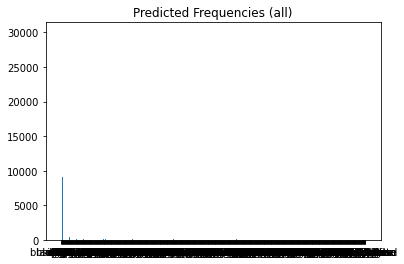

In [21]:
fig, ax = plt.subplots(1)
ax.set_title('Predicted Frequencies (all)')
ax.hist(data,bins=5127)